## Load & Prepare Data

In [7]:
#imports

import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV, ElasticNet, LassoCV
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load data

housing = fetch_california_housing()
X, y = housing.data, housing.target 

# Split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale (important for regularization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Important rule (don’t mess this up)
#Fit scaler on train only
#Transform both train and test

# Without scaling:
# Large-scale features dominate
# Optimization becomes unstable or slow

#Check data 
print(f"Training samples: {X_train.shape[0]}")
print(f"Features: {X_train.shape[1]}")
print(f"Feature names: {housing.feature_names}")


Training samples: 16512
Features: 8
Feature names: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


## Compare All 4 Models 

In [16]:
from sklearn.metrics import r2_score, mean_squared_error

# Train all models with default alpha for regularized ones
models = {
    'LinearRegression': LinearRegression(),
    'Ridge' : Ridge(alpha=1),
    'Lasso' : Lasso(alpha=1),
    'ElasticNet (alpha = 1)' : ElasticNet(alpha=1)
}

results = []

for name, model in models.items(): 

    #train
    model.fit(X_train_scaled, y_train)

    #predict
    y_pred = model.predict(X_test_scaled)  

    #evaluate 
    mse = mean_squared_error(y_test,y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store coefficients
    coefs = model.coef_

    results.append ({
        'Model': name,
        'MSE' : mse,
        'R2' : r2,
        'Coefficients' : coefs
    })

results_df = pd.DataFrame(results)
print("\n\nComparison:")
print(results_df[['Model', 'MSE', 'R2']])



Comparison:
                    Model       MSE        R2
0        LinearRegression  0.555892  0.575788
1                   Ridge  0.555855  0.575816
2                   Lasso  1.310696 -0.000219
3  ElasticNet (alpha = 1)  1.044231  0.203126


## Plot Alpha vs Coefficients 

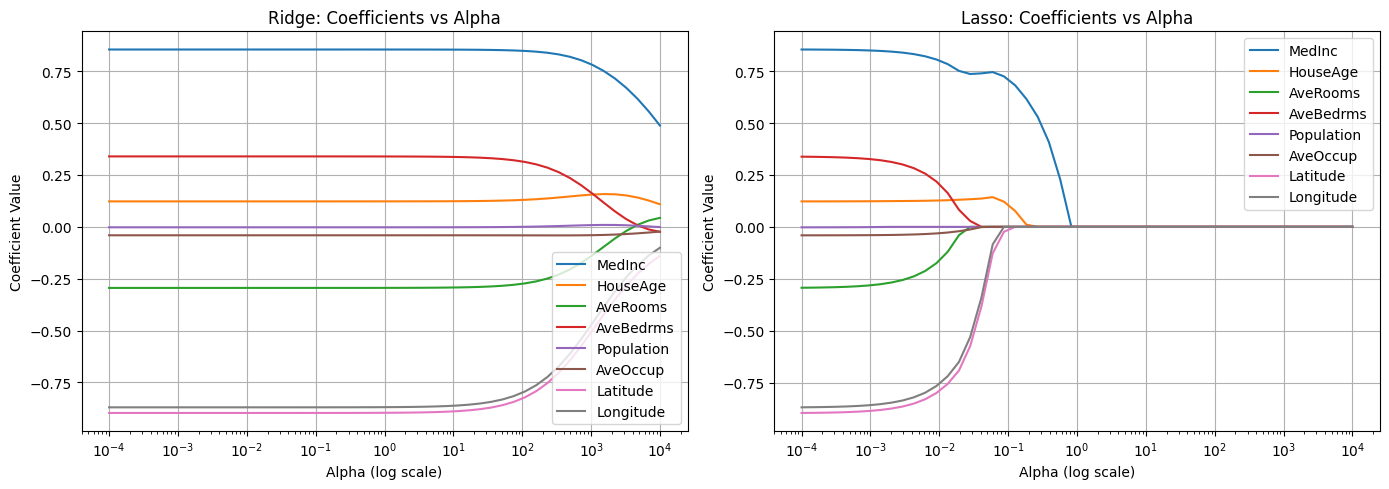

In [17]:
# Try different alpha values
alphas = np.logspace(-4, 4, 50)  # 0.0001 to 10000

# Store coefficients for each alpha
ridge_coefs = []
lasso_coefs = []

for alpha in alphas:
    # Ridge
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, y_train)
    ridge_coefs.append(ridge.coef_)
    
    # Lasso
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train_scaled, y_train)
    lasso_coefs.append(lasso.coef_)

ridge_coefs = np.array(ridge_coefs)
lasso_coefs = np.array(lasso_coefs)

# Plot Ridge
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
for i in range(X_train.shape[1]):
    plt.plot(alphas, ridge_coefs[:, i], label=housing.feature_names[i])
plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Coefficient Value')
plt.title('Ridge: Coefficients vs Alpha')
plt.legend()
plt.grid(True)

# Plot Lasso
plt.subplot(1, 2, 2)
for i in range(X_train.shape[1]):
    plt.plot(alphas, lasso_coefs[:, i], label=housing.feature_names[i])
plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Coefficient Value')
plt.title('Lasso: Coefficients vs Alpha')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

##  Find Best Alpha with CV

In [19]:
alphas_to_try = np.logspace(-2,4,50)
ridge_cv = RidgeCV(alphas=alphas_to_try, cv=5)
ridge_cv.fit(X_train_scaled, y_train)

print(f"Best alpha for Ridge: {ridge_cv.alpha_}")

lasso_cv = LassoCV(cv=5, random_state=42)
lasso_cv.fit(X_train_scaled, y_train)

print(f"Best alpha for Lasso: {lasso_cv.alpha_}")

models_cv = {
    'RidgeCV': ridge_cv,
    'LassoCV': lasso_cv
}

for name, model in models_cv.items():
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"\n{name}:")
    print(f"  MSE: {mse:.4f}")
    print(f"  R²: {r2:.4f}")
    print(f"  Non-zero features: {np.sum(model.coef_ != 0)}/{len(model.coef_)}")

Best alpha for Ridge: 0.01
Best alpha for Lasso: 0.0007985195644260374

RidgeCV:
  MSE: 0.5559
  R²: 0.5758
  Non-zero features: 8/8

LassoCV:
  MSE: 0.5548
  R²: 0.5766
  Non-zero features: 8/8


## Visualize Feature Importance

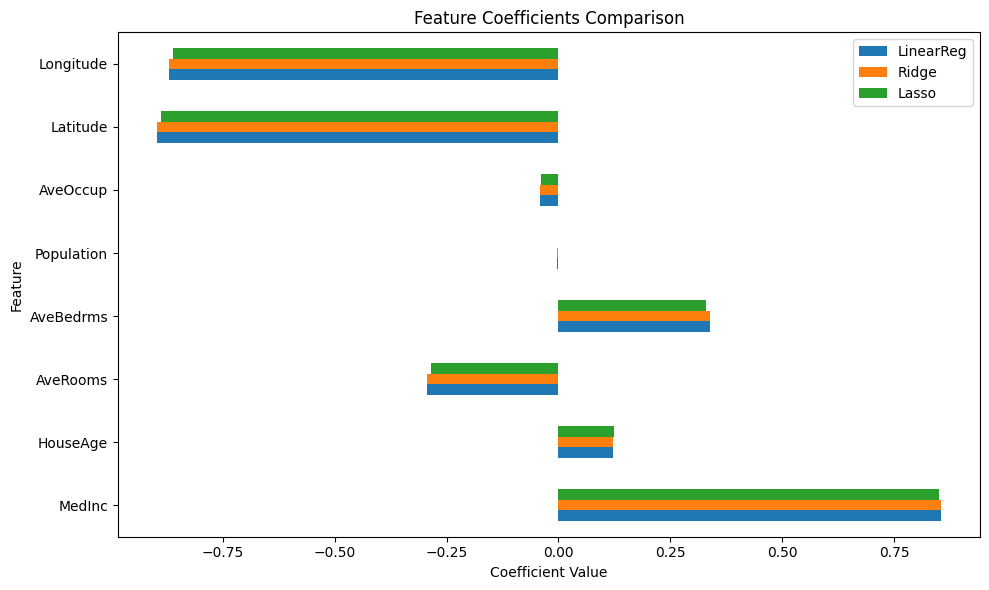



Features dropped by Lasso (coef = 0):
None


In [20]:
# Compare which features matter most
feature_comparison = pd.DataFrame({
    'Feature': housing.feature_names,
    'LinearReg': models['LinearRegression'].coef_,
    'Ridge': ridge_cv.coef_,
    'Lasso': lasso_cv.coef_
})

# Plot coefficients comparison
feature_comparison.set_index('Feature').plot(kind='barh', figsize=(10, 6))
plt.xlabel('Coefficient Value')
plt.title('Feature Coefficients Comparison')
plt.tight_layout()
plt.show()

# Show which features Lasso dropped
print("\n\nFeatures dropped by Lasso (coef = 0):")
dropped = feature_comparison[feature_comparison['Lasso'] == 0]['Feature'].values
print(dropped if len(dropped) > 0 else "None")